# Using Low-Rank Kernel Matrix Approximation on OKGT -- ICD -- Laplace Kernel -- Evaluate the Effect of Number of Components

**Note** Laplace kernel is used throughout this document.

This notebook evaluates the effect of **number of retained columns (ICD)** in applying **incomplete Cholesky decomposition**  for kernel matrix approximation on OKGT. The ICD method is provided in [`PyMC.gp.incomplete_cholesky.ichol_full()`](https://github.com/pymc-devs/pymc/blob/master/pymc/gp/incomplete_chol.f). The function is orignially written in [Fortran](http://ipg.epfl.ch/~seeger/lapmalmainweb/software/index.shtml#chol_incomplete), and PyMC package wrapped it through [F2PY](https://sysbio.ioc.ee/projects/f2py2e/).

The function signature of `ichol_full` looks like the following:

```python
In[2]: from pymc.gp.incomplete_chol import ichol_full
Backend MacOSX is interactive backend. Turning interactive mode on.
In[3]: ?ichol_full
Type:        fortran
String form: <fortran object>
Docstring:
sig,m,p = ichol_full(c,reltol)

Wrapper for ``ichol_full``.

Parameters
----------
c : input rank-2 array('d') with bounds (n,n)
reltol : input float

Returns
-------
sig : rank-2 array('d') with bounds (n,n)
m : int
p : rank-1 array('i') with bounds (n)
```

In this document, we would like to examine the effect of adding additional columns on the optimal transformations. However, `ichol_full` controls the size of the $G$ in $K \approx G G^T$ only through the relative tolerance `reltol`. So the walk-around is to predetermine a grid of values for the relative tolerance instead of controlling the number of columns exactly.

Since `ichol_full` needs the pre-computed Gram matrix. So we will evaluate the non-centered Gram matrix before simulation.

We use the same model which is from [this post](http://partofthething.com/ace/samples.html). The following is the model representation:

$$
Y = \ln (4 + \sin(4X_0)) + |X_1| + X_2^2 + X_3^3 + X_4 + 0.1\epsilon
$$

where $\epsilon \sim N(0,1)$ and each covariate is simulated from $Unif(-1,1)$.

In [93]:
# Simulate data
import okgtreg.simulate as simulate
import okgtreg.kernel_selector as ks
import numpy as np
import scipy as sp
from sklearn.kernel_approximation import Nystroem
from pymc.gp.incomplete_chol import ichol_full
from okgtreg.okgtreg import OKGTReg

np.random.seed(10)
n = 500 # sample size
y, x = simulate.SimData_Wang04(n)
y = np.matrix(y)
x = np.matrix(x)

In [94]:
# Specify the constants, regularization coefficient and kernel functions
eps = 0. # regularization term

p = x.shape[1]
xGroup = [[i+1] for i in range(p)]
# kfn = ks.KernelSelector('Gaussian', sigma=0.5) # Gaussian kernel
kfn = ks.KernelSelector('Laplace', alpha=0.5) # Laplace kernel
# xkfnlist = [kfn]*p
# ykfnlist = [kfn]

Construct Gram matrices (uncentered) beforehand.

In [95]:
Ky = OKGTReg.GramMatrix(y, kfn, centered=False)

Kx = []
for i in range(p):
    Ki = OKGTReg.GramMatrix(x[:,i], kfn, centered=False)
    Kx.append(Ki)

**Number of components** of Nystroem method is the only variable changing throughout the study.

In [97]:
# Define the simulation function

# x, y, n, p, kfn are given globally

def SimulateStudyLaplace_ICD_NumberOfComponents(reltol):

    def ApplyICDOnKernelMatrix(K, reltol):
        L,m,piv = ichol_full(K, reltol) 
        return np.matrix(L[:m]).T, m
    
    m = []
    
    Gy, my = ApplyICDOnKernelMatrix(Ky, reltol)
    m.append(my)
    N0 = np.identity(n) - np.ones((n,n))/n
    Uy, Gy_s, Gy_V = np.linalg.svd(N0 * Gy, full_matrices=0)
    lambday = Gy_s**2
    
    Ux = []
    lambdax = []
    for i in range(p):
        Gi, mi = ApplyICDOnKernelMatrix(Kx[i], reltol)
        m.append(mi)
        Ui, Gi_s, Gi_V = np.linalg.svd(N0 * Gi, full_matrices=0)
        Ux.append(Ui)
        lambdai = Gi_s**2
        lambdax.append(lambdai)
        
    
    
    lambdax_row = np.hstack(lambdax)
    Ux_row = np.hstack(Ux)
    Ux_diag = sp.sparse.block_diag(Ux)

    T = np.diag(lambday / (lambday + eps)) * Uy.T * Ux_row * np.diag(lambdax_row)
    R = np.diag((lambdax_row + eps)**2) + \
            np.diag(lambdax_row) * (Ux_row.T * Ux_row - np.identity(len(lambdax_row))) * np.diag(lambdax_row)

    R_inv = np.linalg.inv(R)
    
    vv = T*R_inv*T.T
    
    my = vv.shape[0]
    eigval, eigvec = sp.linalg.eigh(vv, eigvals=(my-1, my-1))
    
    g_opt = np.diag(lambday) * np.matrix(eigvec)
    g_opt = Uy * g_opt
    
    f_opt = np.diag(np.sqrt(lambday**2 + eps) * lambday) * np.matrix(eigvec)
    f_opt = T.T * f_opt
    f_opt = R_inv * f_opt
    f_opt = np.diag(lambdax_row) * f_opt
    f_opt = Ux_diag * f_opt

    f_opt = f_opt.reshape((n, p), order='F')
    
    return float(eigval), g_opt, f_opt, np.mean(m)

Run simulation

In [99]:
# Run simulation
import time

r2_list = []
g_list = []
f_list = []
time_list = []
m_list = []

# use log-scale
logreltol_grid = np.linspace(np.log10(1. - 1e-9), -6, 500)
reltol_grid = np.power(10., logreltol_grid)

cnt = 0
for reltol in reltol_grid:    
    cnt += 1
    
    start = time.time()
    r2, g, f, mavg = SimulateStudyLaplace_ICD_NumberOfComponents(reltol)
    end = time.time()
    duration = end - start
    
    r2_list.append(r2)
    g_list.append(g)
    f_list.append(f)
    time_list.append(duration)
    m_list.append(mavg)
    
    print cnt, ':', reltol, ',', duration, ',', mavg

1 : 0.999999999 , 0.0217080116272 , 1.0
2 : 0.972693360572 , 0.0240888595581 , 1.0
3 : 0.946132374647 , 0.0183501243591 , 1.0
4 : 0.920296679961 , 0.0198118686676 , 1.0
5 : 0.89516647125 , 0.0324921607971 , 1.0
6 : 0.870722484062 , 0.0199890136719 , 1.0
7 : 0.846945979995 , 0.0205399990082 , 1.16666666667
8 : 0.823818732328 , 0.0227930545807 , 1.16666666667
9 : 0.801323012051 , 0.015969991684 , 1.16666666667
10 : 0.779441574275 , 0.019651889801 , 1.33333333333
11 : 0.758157645009 , 0.0154871940613 , 1.33333333333
12 : 0.737454908305 , 0.0163378715515 , 1.33333333333
13 : 0.717317493746 , 0.0201678276062 , 1.66666666667
14 : 0.697729964287 , 0.0163729190826 , 1.66666666667
15 : 0.678677304413 , 0.0146758556366 , 1.83333333333
16 : 0.660144908633 , 0.0211820602417 , 1.83333333333
17 : 0.642118570285 , 0.0160138607025 , 1.83333333333
18 : 0.624584470641 , 0.0153391361237 , 2.0
19 : 0.607529168316 , 0.0231690406799 , 2.16666666667
20 : 0.590939588966 , 0.0144190788269 , 2.16666666667
21 : 

Plot the time along the **number of components**.

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt

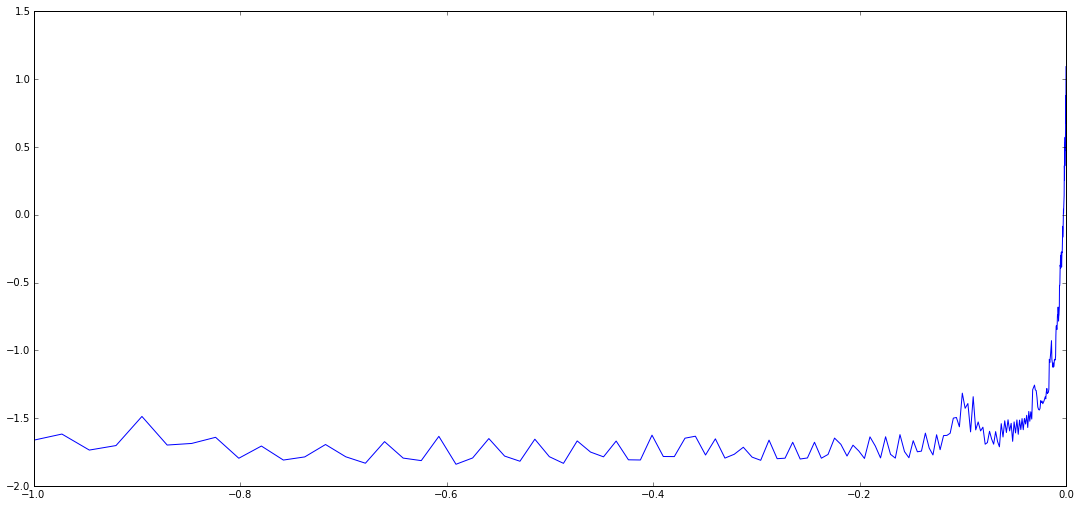

In [108]:
# Time ~ number of components
fig = plt.figure()
fig.set_size_inches(18.5, 8.5)
plt.plot(-reltol_grid, np.log10(time_list)) # x-axis reversed reltol, time is log-transformed

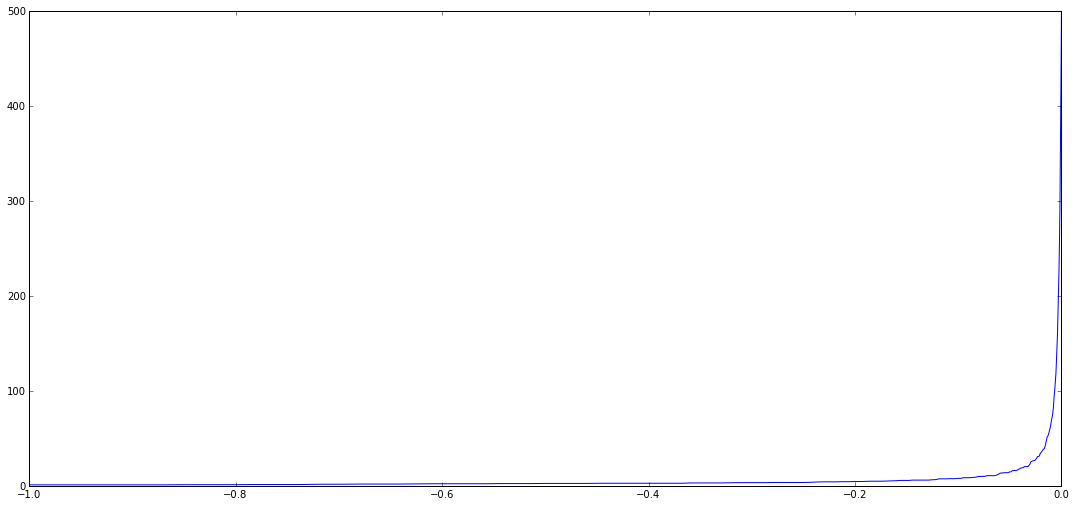

In [109]:
# relative tolerance ~ average number of columns
fig = plt.figure()
fig.set_size_inches(18.5, 8.5)
plt.plot(-reltol_grid, m_list) # x-axis reversed reltol, 

Number of components for stable cases:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176]


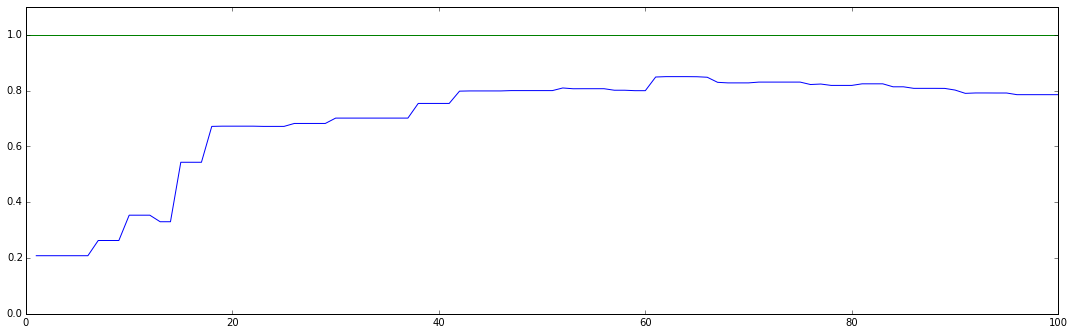

In [105]:
# Plot r2
r2_arr = np.array(r2_list)
# np.max(r2_arr)
r2ind_LessThanOne = np.where(r2_arr < 1)[0]

print 'Number of components for stable cases:\n', r2ind_LessThanOne + 1

fig = plt.figure()
fig.set_size_inches(18.5, 5.5)
plt.plot(r2ind_LessThanOne+1, r2_arr[r2ind_LessThanOne])
plt.axis([0, 100, 0, 1.1])
plt.plot([0,100], [1,1]) # reference line

In this simulation, it shows that after case 176 $R^2$ blows up. <font color='red'>This is an indication of numerical instability.</font>

In [116]:
print 'Case 176:'
print 'R2 =', r2_list[175]

Case 176:
R2 = 0.998770640737


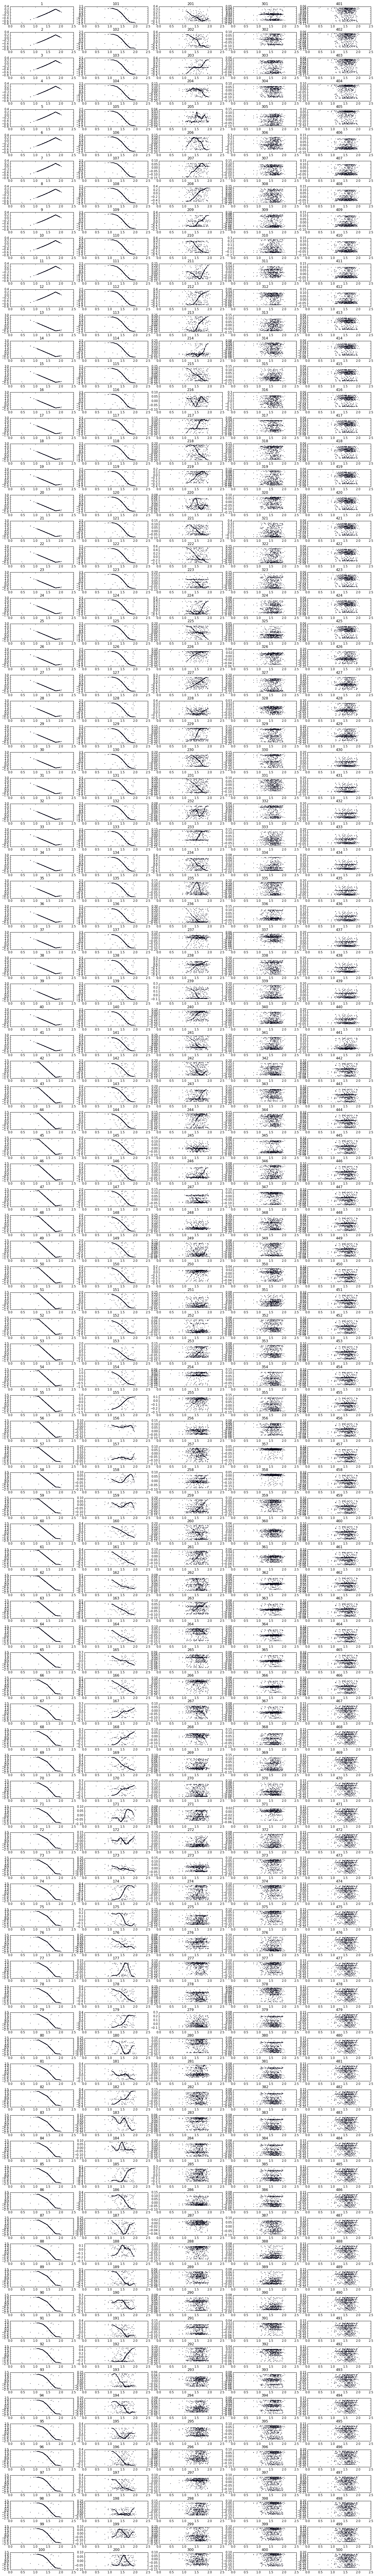

In [103]:
# Plot g
# nPlots = 50

subplot_width = 3.5 # inch
subplot_height = 1.2

nrow = 100
ncol = 5
fig, axarr = plt.subplots(nrow, ncol)
fig.set_size_inches(ncol*subplot_width, nrow*subplot_height)
fig.tight_layout()

for j in range(ncol):
    for i in range(nrow):
        axarr[i,j].scatter(y, g_list[j*nrow + i], s=0.5)
        axarr[i,j].set_title(j*nrow + i + 1)

Transformation becomes unstable after case 156 where we have:

In [111]:
print 'Case 156:'
print 'Average number of columns:', m_list[155]
print 'R2 =', r2_list[155]

Case 156:
Average number of columns: 51.6666666667
R2 = 0.916408855098


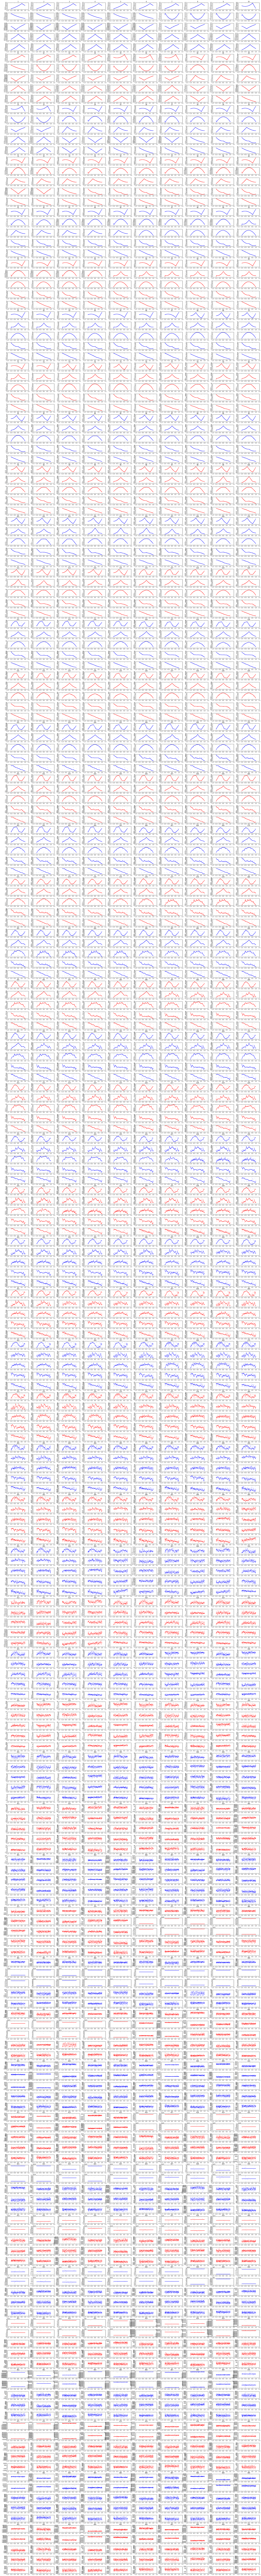

In [104]:
# Plot f

# nTrials = 2
# nPlots = nTrials * 4

subplot_width = 3
subplot_height = 1.2

nrow = 5 # 5 X variables
ncol = 10
nrowblocks = 50 # ncol*nrowblocks cases

fig, axarr = plt.subplots(nrow*nrowblocks, ncol)
fig.set_size_inches(subplot_width*ncol, subplot_height*nrow*nrowblocks)
fig.tight_layout()

for k in range(nrowblocks):
    if k%2 == 1:
        plot_color = 'r'
    else:
        plot_color = 'b'
    for j in range(ncol):
        axarr[k*nrow,j].set_title(k*ncol + j + 1)
        for i in range(nrow):
            axarr[k*nrow+i, j].scatter(x[:,i], f_list[k*nrow+j][:,i], s=0.5, color=plot_color)